In [1]:
import os
import math
import random
from typing import Dict, Literal

import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt

files = os.listdir('DataSujetos/')

In [2]:
class Experiment():
    
    def __init__(self, density: float):
        self.density = density
        algorithms = ['louvain', 'girvan', 'lpa']
        self._data = {x: {'modularity': {}, 'NC': {}} for x in algorithms}
        
    def set_experiment_data(self, 
                            data: Dict[str, float], 
                            algo: Literal['louvain', 'girvan', 'lpa'], 
                            measurement: Literal['modularity', 'NC']) -> None:
        self._data[algo][measurement].update(data)
            
    def get_estadio_data(self, 
                        algo: Literal['louvain', 'girvan', 'lpa'],
                        measurement: Literal['modularity', 'NC'],
                        estadio: Literal['W', 'N1', 'N2', 'N3']) -> np.ndarray:
        res = []
        for k, v in self._data[algo][measurement].items():
            if k.startswith(estadio):
                res.append(v)
        return np.array(res)

In [3]:
def find_threshold(adj_matrix: np.ndarray, density: float, epsilon: int=2) -> float:
    size = adj_matrix.shape
    N = size[0]*size[1]
    left = adj_matrix.min()
    right = adj_matrix.max()
    target = math.ceil(N*density)
    res = N
    cnt = 0
    while res!=target:
        cnt+=1
        if cnt == 100:
            print('Have not converged in 1000 iterations, returning suboptimal threshold')
            return guess
        guess = (left+right)/2
        res = np.sum(adj_matrix>=guess)
        if (res>=target-epsilon) and (res<=target+epsilon):
            return guess
        elif res<target:
            right = guess
        else:
            left = guess


def run_louvain(G: nx.Graph, f: str, exp: Experiment) -> None:
    Louv_comms = nx.community.louvain_communities(G, seed=158151)
    Louv_NC = len([x for x in Louv_comms if len(x)>1])
    Louv_Q = nx.community.modularity(G, Louv_comms)
    exp.set_experiment_data({f: Louv_Q}, 'louvain', 'modularity')
    exp.set_experiment_data({f: Louv_NC}, 'louvain', 'NC')
    

def run_girvan(G: nx.Graph, f: str, exp: Experiment) -> None:
    Girvan_generator = nx.community.girvan_newman(G)
    Girvan_comms = next(Girvan_generator)
    Girvan_NC = len([x for x in Girvan_comms if len(x)>1])
    Girvan_Q = nx.community.modularity(G, Girvan_comms)
    exp.set_experiment_data({f: Girvan_Q}, 'girvan', 'modularity')
    exp.set_experiment_data({f: Girvan_NC}, 'girvan', 'NC')

    
def run_lpa(G: nx.Graph, f: str, exp: Experiment) -> None:
    LPA_comms = nx.community.label_propagation_communities(G)
    LPA_NC = len([x for x in LPA_comms if len(x)>1])
    LPA_Q = nx.community.modularity(G, LPA_comms)
    exp.set_experiment_data({f: LPA_Q}, 'lpa', 'modularity')
    exp.set_experiment_data({f: LPA_NC}, 'lpa', 'NC')
    
    
def graph_factory(adjmat: np.ndarray) -> nx.Graph:
    adjmat -= np.diag(np.diag(adjmat))
    thr = find_threshold(adjmat, d)
    adjmat = adjmat>=thr
    G = nx.from_numpy_array(adjmat)
    return G
    

def reset_avg(estadio_avg_graph: Dict[str, np.ndarray], cnt_by_estadio: Dict[str, int]) -> None:
    for k in estadio_avg_graph:
        estadio_avg_graph[k] = np.zeros((116, 116))
        cnt_by_estadio[k] = 0

In [9]:
%%time

densities = np.linspace(0.005, 0.15, num=15)
experiments = [Experiment(d) for d in densities]
estadio_avg_graph = {
    'W': np.zeros((116, 116)),
    'N1': np.zeros((116, 116)),
    'N2': np.zeros((116, 116)),
    'N3': np.zeros((116, 116)),
}
cnt_by_estadio = {
    'W': 0,
    'N1': 0,
    'N2': 0,
    'N3': 0,
}

for i, d in enumerate(densities):
    print(f'Start with density {d}')
    for f in files:
        exp = experiments[i]
        adjmat = pd.read_csv('DataSujetos/'+f, header=None).values
        for k in estadio_avg_graph:
            if f.startswith(k):
                estadio_avg_graph[k] += adjmat
                cnt_by_estadio[k] += 1
        G = graph_factory(adjmat)
        run_louvain(G, f, exp)
        run_girvan(G, f, exp)
        run_lpa(G, f, exp)
    for k in estadio_avg_graph:
        adjmat = estadio_avg_graph[k]/cnt_by_estadio[k]
        G = graph_factory(adjmat)
        run_louvain(G, f'avg_{k}', exp)
        run_girvan(G, f'avg_{k}', exp)
        run_lpa(G, f'avg_{k}', exp)
    for cnt in range(18):
        ERG = nx.erdos_renyi_graph(n=116, p=d, seed=random.randint(0,1000000), directed=False)
        run_louvain(ERG, f'ER_{cnt}', exp)
        run_girvan(ERG, f'ER_{cnt}', exp)
        run_lpa(ERG, f'ER_{cnt}', exp)
    reset_avg(estadio_avg_graph, cnt_by_estadio)

Start with density 0.005
Start with density 0.015357142857142857
Start with density 0.025714285714285714
Start with density 0.03607142857142857
Start with density 0.04642857142857142
Start with density 0.05678571428571428
Start with density 0.06714285714285714
Start with density 0.0775
Start with density 0.08785714285714286
Start with density 0.09821428571428571
Start with density 0.10857142857142857
Start with density 0.11892857142857143
Start with density 0.12928571428571428
Start with density 0.13964285714285712
Start with density 0.15
CPU times: total: 6min 3s
Wall time: 6min 4s


In [10]:
estadios = ['W', 'N1', 'N2', 'N3', 'ER']

Qs = {e: [exp.get_estadio_data('louvain', 'modularity', e) for exp in experiments] for e in estadios}
QCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in Qs.items()}
Qavgs = {e: [np.mean(x) for x in data] for e, data in Qs.items()}
NCs = {e: [exp.get_estadio_data('louvain', 'NC', e) for exp in experiments] for e in estadios}
NCCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in NCs.items()}
NCavgs = {e: [np.mean(x) for x in data] for e, data in NCs.items()}

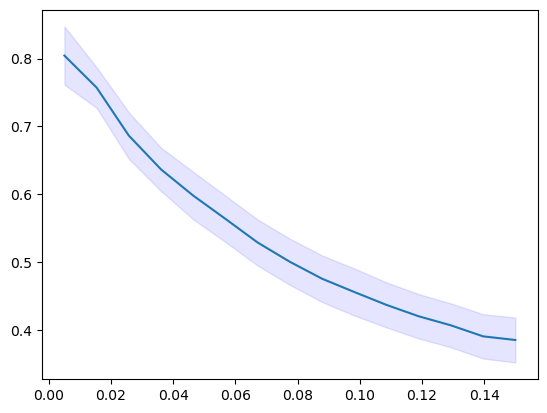

In [16]:
fig, ax = plt.subplots()
y = np.array(Qavgs['W'])
ci = np.array(QCIs['W'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

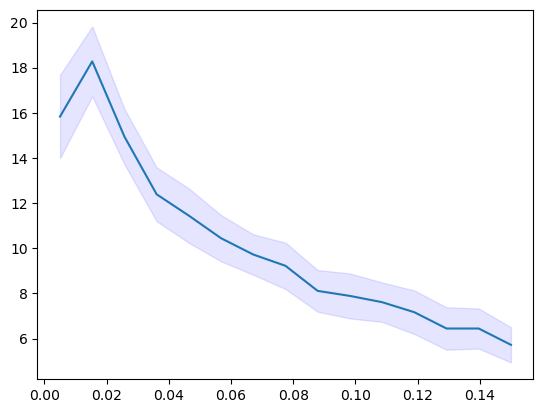

In [17]:
fig, ax = plt.subplots()
y = np.array(NCavgs['W'])
ci = np.array(NCCIs['W'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

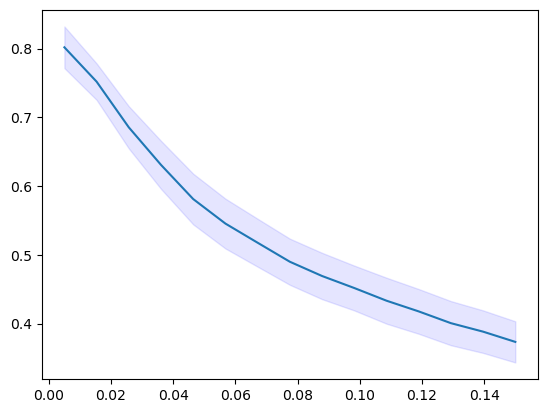

In [18]:
fig, ax = plt.subplots()
y = np.array(Qavgs['N1'])
ci = np.array(QCIs['N1'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

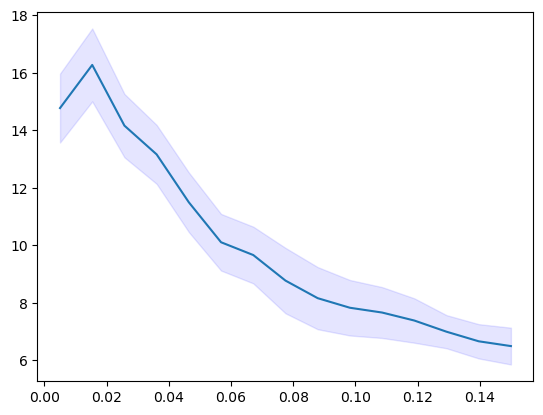

In [19]:
fig, ax = plt.subplots()
y = np.array(NCavgs['N1'])
ci = np.array(NCCIs['N1'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

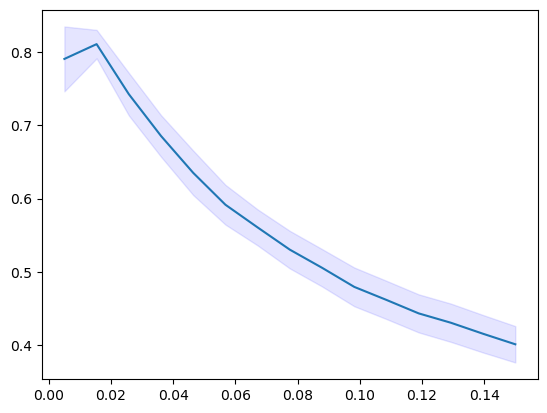

In [22]:
fig, ax = plt.subplots()
y = np.array(Qavgs['N2'])
ci = np.array(QCIs['N2'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

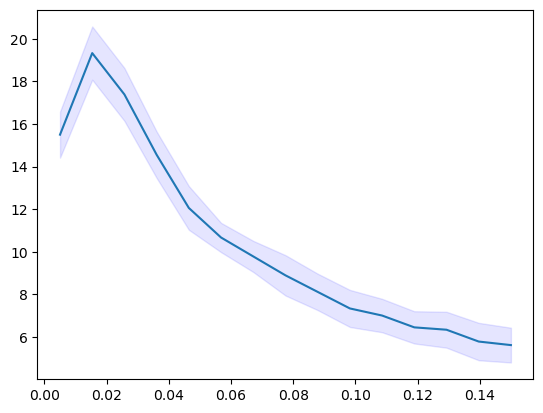

In [23]:
fig, ax = plt.subplots()
y = np.array(NCavgs['N2'])
ci = np.array(NCCIs['N2'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

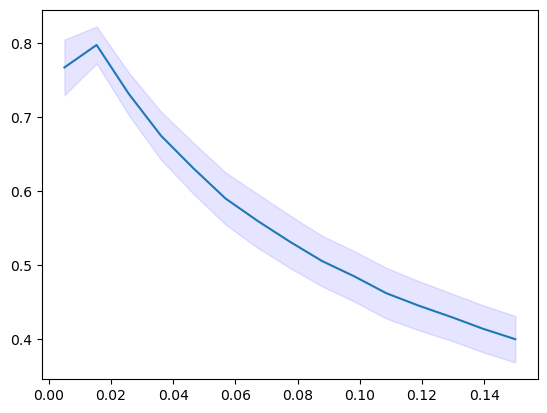

In [24]:
fig, ax = plt.subplots()
y = np.array(Qavgs['N3'])
ci = np.array(QCIs['N3'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

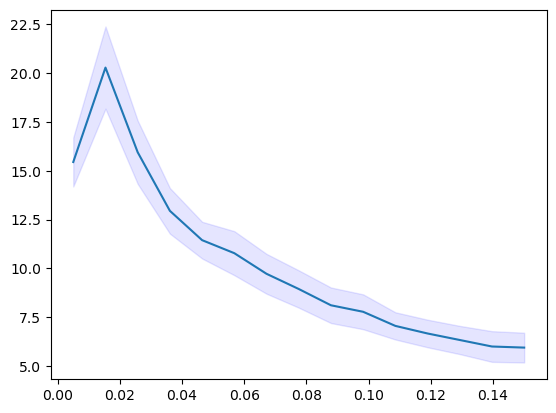

In [25]:
fig, ax = plt.subplots()
y = np.array(NCavgs['N3'])
ci = np.array(NCCIs['N3'])
x = densities
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

In [30]:
QT_W = [np.mean(x) for x in Qs['W']]
QT_N1 = [np.mean(x) for x in Qs['N1']]
QT_N2 = [np.mean(x) for x in Qs['N2']]
QT_N3 = [np.mean(x) for x in Qs['N3']]
QT_ER = [np.mean(x) for x in Qs['ER']]

NCT_W = [np.mean(x) for x in NCs['W']]
NCT_N1 = [np.mean(x) for x in NCs['N1']]
NCT_N2 = [np.mean(x) for x in NCs['N2']]
NCT_N3 = [np.mean(x) for x in NCs['N3']]
NCT_ER = [np.mean(x) for x in NCs['ER']]

print(f'W: {ttest_ind(QT_W, QT_ER, equal_var=False)}')
print(f'N1: {ttest_ind(QT_N1, QT_ER, equal_var=False)}')
print(f'N2: {ttest_ind(QT_N2, QT_ER, equal_var=False)}')
print(f'N3: {ttest_ind(QT_N3, QT_ER, equal_var=False)}')

W: Ttest_indResult(statistic=2.5055528104659266, pvalue=0.019568683630449148)
N1: Ttest_indResult(statistic=2.3930750402311634, pvalue=0.02504176947467505)
N2: Ttest_indResult(statistic=2.9296075764468146, pvalue=0.007351749112705957)
N3: Ttest_indResult(statistic=2.9069399057888092, pvalue=0.007892407788773413)


In [35]:
ttest_ind(QT_W, QT_ER, equal_var=False).pvalue

0.019568683630449148

In [36]:
pvals = [ttest_ind(QT_W, QT_ER, equal_var=False).pvalue,
        ttest_ind(QT_N1, QT_ER, equal_var=False).pvalue,
        ttest_ind(QT_N2, QT_ER, equal_var=False).pvalue,
        ttest_ind(QT_N3, QT_ER, equal_var=False).pvalue,]
fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False)

(array([ True,  True,  True,  True]),
 array([0.02504177, 0.02504177, 0.01578482, 0.01578482]))

In [31]:
QT_W = [np.mean(x) for x in Qs['W']]
QT_N1 = [np.mean(x) for x in Qs['N1']]
QT_N2 = [np.mean(x) for x in Qs['N2']]
QT_N3 = [np.mean(x) for x in Qs['N3']]
QT_ER = [np.mean(x) for x in Qs['ER']]

NCT_W = [np.mean(x) for x in NCs['W']]
NCT_N1 = [np.mean(x) for x in NCs['N1']]
NCT_N2 = [np.mean(x) for x in NCs['N2']]
NCT_N3 = [np.mean(x) for x in NCs['N3']]
NCT_ER = [np.mean(x) for x in NCs['ER']]

print(f'W: {ttest_ind(NCT_W, NCT_ER, equal_var=False)}')
print(f'N1: {ttest_ind(NCT_N1, NCT_ER, equal_var=False)}')
print(f'N2: {ttest_ind(NCT_N2, NCT_ER, equal_var=False)}')
print(f'N3: {ttest_ind(NCT_N3, NCT_ER, equal_var=False)}')

W: Ttest_indResult(statistic=1.112318718149687, pvalue=0.2758387306847029)
N1: Ttest_indResult(statistic=1.1006187535198557, pvalue=0.2804536919281575)
N2: Ttest_indResult(statistic=1.1480016136403302, pvalue=0.2618854524014913)
N3: Ttest_indResult(statistic=1.1140240869229168, pvalue=0.2756714766829652)


In [32]:
print(f'W vs N1: {ttest_ind(QT_N1, QT_W, equal_var=False)}')
print(f'W vs N2: {ttest_ind(QT_N2, QT_W, equal_var=False)}')
print(f'W vs N3: {ttest_ind(QT_N3, QT_W, equal_var=False)}')

W vs N1: Ttest_indResult(statistic=-0.1466750592527939, pvalue=0.8844394944347587)
W vs N2: Ttest_indResult(statistic=0.5862939750555622, pvalue=0.5623782836717806)
W vs N3: Ttest_indResult(statistic=0.5170872416141019, pvalue=0.6091579566532801)


In [33]:
print(f'W vs N1: {ttest_ind(NCT_N1, NCT_W, equal_var=False)}')
print(f'W vs N2: {ttest_ind(NCT_N2, NCT_W, equal_var=False)}')
print(f'W vs N3: {ttest_ind(NCT_N3, NCT_W, equal_var=False)}')

W vs N1: Ttest_indResult(statistic=-0.10372615562926271, pvalue=0.9181443248369023)
W vs N2: Ttest_indResult(statistic=0.13706952291269067, pvalue=0.8919831747639848)
W vs N3: Ttest_indResult(statistic=0.07779604936735557, pvalue=0.9385517528812973)


In [71]:
%%time

avg_graphs = {}

for i, d in enumerate([0.06]):
    print(f'Start with density {d}')
    for f in files:
        adjmat = pd.read_csv('DataSujetos/'+f, header=None).values
        for k in estadio_avg_graph:
            if f.startswith(k):
                estadio_avg_graph[k] += adjmat
                cnt_by_estadio[k] += 1
    for k in estadio_avg_graph:
        adjmat = estadio_avg_graph[k]/cnt_by_estadio[k]
        G = graph_factory(adjmat)
        avg_graphs[k] = G
        
communities = {
    k: nx.community.louvain_communities(v, seed=158151) for k, v in avg_graphs.items()
}

Start with density 0.06
CPU times: total: 422 ms
Wall time: 424 ms


In [72]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

C:\Users\USER\AppData\Local\Temp\ipykernel_8108\4134226023.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


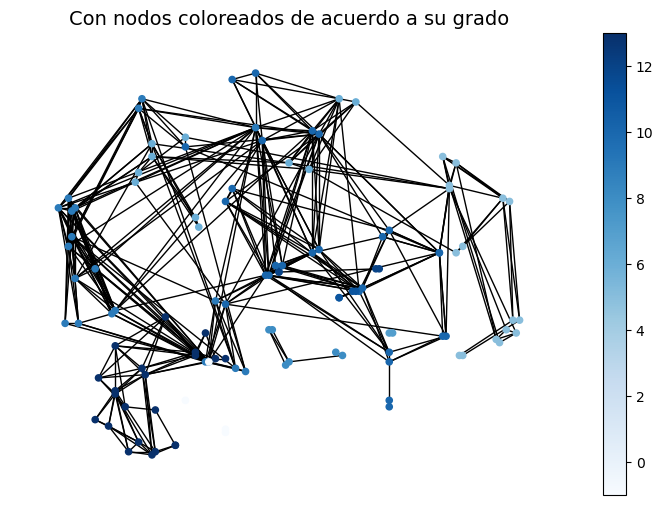

In [75]:
G = avg_graphs['W']
comm_color = [-1 for i in range(116)]
for i, comm in enumerate(communities['W']):
    for node in comm:
        comm_color[node] = i+5 if len(comm)>1 else -1
n=116
nodes = G.nodes()
plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(comm_color)
vmax = max(comm_color)
cmap=plt.cm.Blues
nx.draw(G, layout, node_size=20, node_color=comm_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm)

C:\Users\USER\AppData\Local\Temp\ipykernel_8108\3528070505.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


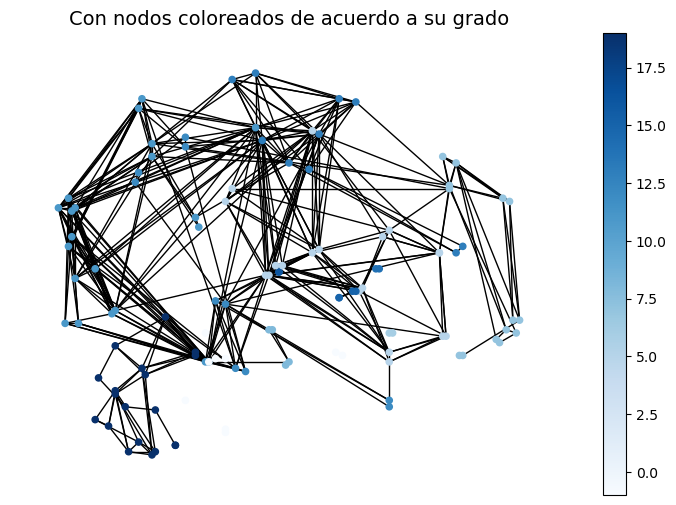

In [76]:
G = avg_graphs['N1']
comm_color = [-1 for i in range(116)]
for i, comm in enumerate(communities['N1']):
    for node in comm:
        comm_color[node] = i+5 if len(comm)>1 else -1
n=116
nodes = G.nodes()
plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(comm_color)
vmax = max(comm_color)
cmap=plt.cm.Blues
nx.draw(G, layout, node_size=20, node_color=comm_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm)

C:\Users\USER\AppData\Local\Temp\ipykernel_8108\1723900518.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


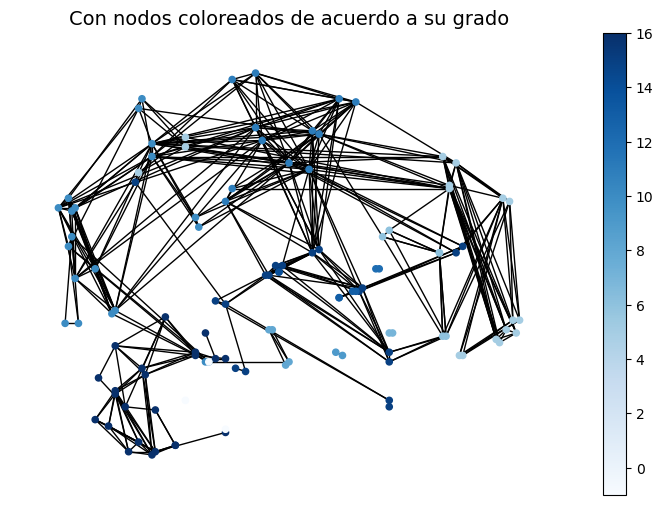

In [77]:
G = avg_graphs['N2']
comm_color = [-1 for i in range(116)]
for i, comm in enumerate(communities['N2']):
    for node in comm:
        comm_color[node] = i+5 if len(comm)>1 else -1
n=116
nodes = G.nodes()
plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(comm_color)
vmax = max(comm_color)
cmap=plt.cm.Blues
nx.draw(G, layout, node_size=20, node_color=comm_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm)

C:\Users\USER\AppData\Local\Temp\ipykernel_8108\3103550784.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


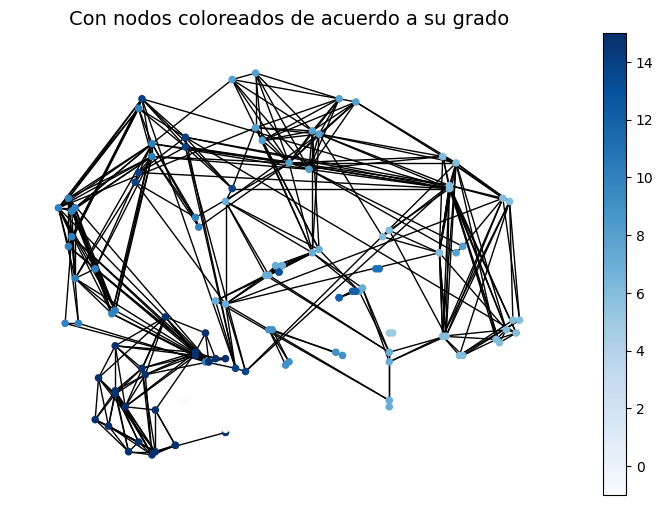

In [78]:
G = avg_graphs['N3']
comm_color = [-1 for i in range(116)]
for i, comm in enumerate(communities['N3']):
    for node in comm:
        comm_color[node] = i+5 if len(comm)>1 else -1
n=116
nodes = G.nodes()
plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(comm_color)
vmax = max(comm_color)
cmap=plt.cm.Blues
nx.draw(G, layout, node_size=20, node_color=comm_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm)